First we need to import used libraries:

In [12]:
import tensorflow as tf, pandas as pd, matplotlib.pyplot as plt, numpy as np, os
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.utils import load_img, plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Prepare data from each dataset so that we end up with normalized pixels and labels:

In [13]:
def prepare_data(choice):
    match choice:
        case 1:
            df = pd.read_csv(os.getcwd() + "//datasets//age_gender.csv")
            df = shuffle(df)

            # image size originally is 48
            img_size = 48

            # First split each pixel value and convert to float, only then we can normalize values of pixels from 0 - 255 to 0 - 1:
            df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype = "float32"))
            df['pixels'] = df['pixels'].apply(lambda x: x / 255)

            x = np.array(df['pixels'].tolist())
            # x.shape[0] = 23705, those are number of entries in db file, last argument is 1 if greyscale, 3 if rgb images
            x = x.reshape(x.shape[0], img_size, img_size, 1)

            y_age = np.array(df['age'])
            y_ethnicity = np.array(df['ethnicity'])
            y_gender = np.array(df['gender'])
            return x, y_age, y_gender, y_ethnicity, img_size
        case 2:
            directory = os.getcwd() + '//datasets//UTKFace//'

            # image size originally is 200
            img_size = 200
            
            # labels - age, gender, ethnicity
            image_paths = []
            age_labels = []
            gender_labels = []

            for filename in os.listdir(directory):
                image_path = os.path.join(directory, filename)
                temp = filename.split('_')
                age = int(temp[0])
                gender = int(temp[1])
                image_paths.append(image_path)
                age_labels.append(age)
                gender_labels.append(gender)

            # convert to dataframe
            df = pd.DataFrame()
            df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

            x = []
            for image in df['image']:
                    img = load_img(image, color_mode = "grayscale")
                    img = img.resize((img_size, img_size), 3)
                    img = np.array(img)
                    x.append(img)

            x = np.array(x)
            x = x.reshape(len(x), img_size, img_size, 1)
            x = x/255.0

            y_gender = np.array(df['gender'])
            y_age = np.array(df['age'])
            if 'ethnicity' in df.columns:
                y_ethnicity = np.array(df['ethnicity'])
            else:
                y_ethnicity = np.empty(0)
            return x, y_age, y_gender, y_ethnicity, img_size
        case 3:
            
            return 0
        case _:
            return 0,0,0,0,0

First, we pick the dataset that we would like to use from:
<br>1 - Age, gender, ethnicity CSV
<br>2 - UTKFace
<br>3 - Fairface

In [14]:
choice = 1

In [15]:
x, y_age, y_gender, y_ethnicity, img_size = prepare_data(choice = choice)

Display some exemplary images:

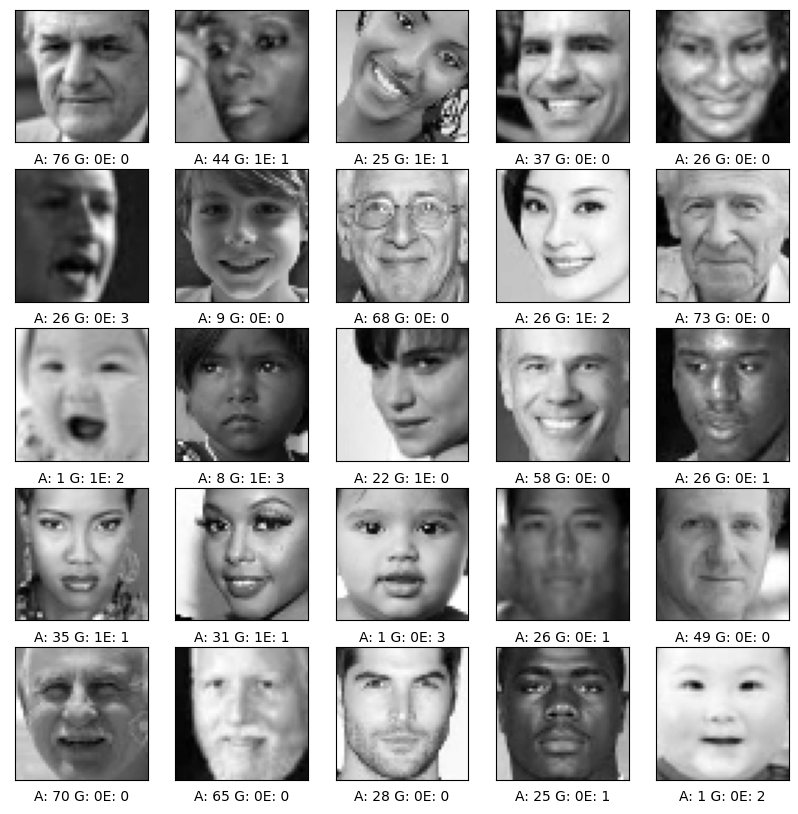

In [16]:
# size of the whole grid of images
plt.figure(figsize=(10, 10))

# display first 25 images in a 5x5 grid
for i in range(0, 25):
    plt.subplot(5, 5, (i % 25) + 1)
    plt.grid(False)
    #disable x and y axis description
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x[i].reshape(img_size, img_size), cmap='gray')
    # could add mapping that if G = 0 then male, = 1 then female and similar with ethnicity
    # A = age, G = gender, E = ethnicity
    plt.xlabel("A: "+ str(y_age[i]) + " G: " + str(y_gender[i]) + (" E: " + str(y_ethnicity[i]) if y_ethnicity.size > 0 else ""))
plt.show()

## [1] Age and Gender Prediction From Face Images Using Attentional Convolutional Network

<img src="images/[1]Attentional Convolutional Network.png">

In [17]:
inputs = Input((img_size, img_size, 1))

#instead of building model the classical way, we can add to separate hidden layers which would check for both age and gender and then pass to individual output layers
layer = Conv2D(32, kernel_size = (3, 3), strides = 1, padding = "same", activation = 'relu') (inputs)
layer = MaxPooling2D(pool_size = (2, 2)) (layer)

layer = Conv2D(64, kernel_size = (3, 3), strides = 1, padding = "same", activation = 'relu') (layer)
layer = MaxPooling2D(pool_size = (2, 2)) (layer)

layer = Conv2D(128, kernel_size = (3, 3), strides = 1, padding = "same", activation = 'relu') (layer)
layer = MaxPooling2D(pool_size = (2, 2)) (layer)

layer = Conv2D(256, kernel_size = (3, 3), strides = 1, padding = "same", activation = 'relu') (layer)
layer = MaxPooling2D(pool_size = (2, 2)) (layer)

layer = Flatten() (layer)

Dense_1 = Dense(256, activation='relu') (layer)
Dense_2 = Dense(256, activation='relu') (layer)

Dropout_1 = Dropout(0.3) (Dense_1)
Dropout_2 = Dropout(0.3) (Dense_2)

Dense_output_1 = Dense(1, activation='softmax', name='gender_out') (Dropout_1)
Dense_output_2 = Dense(1, activation='softmax', name='age_out') (Dropout_2)

model = Model(inputs = [inputs], outputs = [Dense_output_1, Dense_output_2])

model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy'])

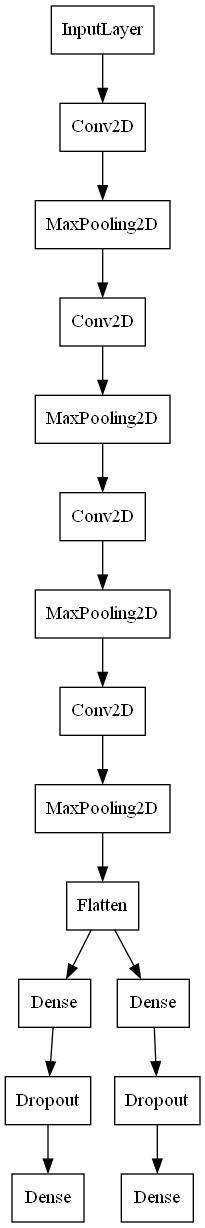

In [18]:
# change name of plotted model to dynamic variable based on network implemented from referenced papers e.g. 1_model.png, or abbreviation_model.png 
plot_model(model = model, to_file = os.getcwd() + '//images//model.png', show_layer_names = False)

Training:

In [19]:
# we might use validation_split or we can divide sets as before which allows for reproducibility:
# seed = 100
# x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size = 0.2, random_state = seed)
# x_train_ethnicity, x_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(x, y_ethnicity, test_size = 0.2, random_state = seed)

history = model.fit(x, [y_age, y_gender] , epochs = 20, validation_split = 0.2)

Epoch 1/20
593/593 [==============================] - 42s 67ms/step - loss: -10782943819595776.0000 - gender_out_loss: -10782943819595776.0000 - age_out_loss: 0.5213 - gender_out_accuracy: 0.0475 - age_out_accuracy: 0.4787 - val_loss: -83047530585128960.0000 - val_gender_out_loss: -83047530585128960.0000 - val_age_out_loss: 0.5284 - val_gender_out_accuracy: 0.0468 - val_age_out_accuracy: 0.4716
Epoch 2/20
593/593 [==============================] - 41s 70ms/step - loss: -1737689891891838976.0000 - gender_out_loss: -1737689891891838976.0000 - age_out_loss: 0.5213 - gender_out_accuracy: 0.0475 - age_out_accuracy: 0.4787 - val_loss: -5941999430524731392.0000 - val_gender_out_loss: -5941999430524731392.0000 - val_age_out_loss: 0.5284 - val_gender_out_accuracy: 0.0468 - val_age_out_accuracy: 0.4716
Epoch 3/20
593/593 [==============================] - 41s 68ms/step - loss: -24614841577812000768.0000 - gender_out_loss: -24614841577812000768.0000 - age_out_loss: 0.5213 - gender_out_accuracy: 0

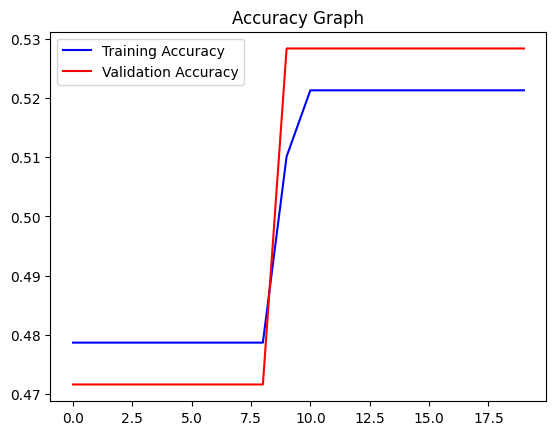

In [25]:
acc = np.array(history.history['age_out_accuracy'])
val_acc = np.array(history.history['val_age_out_accuracy'])
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()